<a href="https://colab.research.google.com/github/Yurovskyy/TP3/blob/main/TP3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Participantes
Yuri Fonseca Lopes - 214450006

# 1. Formalização do problema

## 1.1 Contextualização

Existem várias maneiras de avaliar o desempenho de uma empresa para decidir se é válido comprar ações da mesma. Alguns métodos existentes são:

CAPM (Modelo de precificação de ativos de capital). É um método que analise a relação entre o risco e o retorno que é esperado de um investimento, obtido a partir de princípios de diversificação com pressupostos simplificados.

HME (Hipótese do mercado eficiente). Essa hipótese afirma que os mercados são eficientes, ou seja, um agente não consegue alcançar consistentemente retornos superioers à média do mercado, pois os preços dos ativos refletem toda a informação disponível em um dado momento de tempo.

Análise técnica. É uma busca por padrões recorrentes e previsíveis nos preços do ativo.

Análise Fundamentalista. Utiliza indicadores financeiros, de gestão, do negócio e do risco da empresa, além de índices macroeconômicos na busca de determinar o valor presente descontado dos fluxos de caixa da empresa para chegar ao valor justo de cada ação.

# 2. Mudanças em relação ao TP1

## 2.1 Motivações

No TP1, eu mapeei os Índices de Governança para valores numéricos e apliquei o K-means nesses novos valores somados. ~~Nesse trabalho não irei realizar essa soma, irei inserir todos os 54 Índices de Governça. Por conta disso, urei usar redução de dimensionalidade para visualização dos clusters.~~
O Marcos disponibilizou um novo banco de dados já trabalhado, que contém um mapeamento e somatório ponderado das respostas das empresas, seguindo:

- 0 -> não se aplica
- 1 -> não
- 2 -> parcialmente
- 3 -> sim

e a ponderação dada por:

$$GC_i=(\frac{1}{N_i.W_{max}}).\sum_{j=1}^{N_i}w_{ij}$$

"Em que GC i é indicador de governança corporativa padronizado, correspondente ao capítulo i; Ni representa o número total de perguntas no questionário do capítulo i; wij refere-se ao peso atribuído à resposta j no capítulo i, de acordo com a escala escolhida; Wmax representa o peso máximo atribuído a uma resposta, conforme definido pela escala escolhida, ou seja, o valor é igual a 3 para este estudo".

Fiz uma revisão na literatura (pesquisei assuntos internacionais) que acabou comprovando uma ideia (no meio das milhoes que eu tinha) que eu tive no TP1. Empresas que não pontuam bem no Social e Ambiental (Social and Enviromental) e pontuaram bem em Governança acabam tendo rendimentos maiores que as demais. Fonte: https://www.sciencedirect.com/science/article/pii/S221484502200093X.

O Marcos também me mandou um artigo que encontra uma relação equivalente para o cenário Brasileiro, onde empresas com alto DR tendem a ter retorno menor. (Não tenho certeza se posso compartilhar o artigo do Marcos, por isso não coloquei o link dele aqui).

~~Esse trabalho citado usou clusterização com o Kmeans++ na bolsa da Turquia. Vou tentar preparar o ambiente para fazer o mesmo aqui com a Bolsa Brasileira. Contudo, terei que adquirir novos dados, pois a base de dados ainda não conta com o rendimento (e outros indicadores de empresas). O trabalho citado usou uma base de dados paga 😒~~

Como dito, usarei a nova base de dados cedida pelo Marcos, que atualmente se encontra em: https://github.com/Yurovskyy/TP3/blob/main/output.csv

Essa nova abordagem continua sendo relevante, pois possibilita a identificação de Indices de Governança específicos que indicam bons rendimentos. Com esse novo conhecimento, podemos por exemplo identificar uma empresa que irá realizar um IPO e prever o rendimento dela com base nos possíveis índices que a mesma irá cumprir durante o tempo.

## 2.1 Hipóteses a serem investigadas e possíveis análises

1. Testar via clusterização o que foi mostrado no artigo, ou seja, empresas com alto DR tem retornos baixos.

2. Achar um cluster de empresas com alto retorno e analisar a soma ponderada dos índices das mesmas.

3. Visualizar o cluster de empresas com alto retorno, ver o tipo de empresa, tamanho, valor de mercado.

4. Aplicar uma regressão para tentar estimar o retorno das empresas com base na soma pondera dos índices.

# 3. Análise exploratória de dados (EDA)

In [26]:
# @title Realizando os imports necessários

import pandas as pd
import requests
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from matplotlib import pyplot as plt
import plotly.express as px

In [2]:
# @title Carregando o dataset

# URL do arquivo CSV
url = 'https://github.com/Yurovskyy/TP3/raw/main/output.csv'

# Baixar o arquivo CSV da web
response = requests.get(url)

# Verificar se a solicitação foi bem-sucedida
if response.status_code == 200:
    # Ler o conteúdo do arquivo CSV usando o Pandas
    df = pd.read_csv(url)

# Se a solicitação não for bem-sucedida
else:
    print('Falha ao baixar o arquivo CSV.')


In [3]:
# @title Exploração inicial do dataset

dimensoes = df.shape
print("Número de entradas(linhas):", dimensoes[0])
print("Número de colunas(variáveis):", dimensoes[1])

# identificar o tipo de cada variável
display(df.dtypes)

# ver as 5 primeiras entradas do conjunto de treino
display(df.head())

Número de entradas(linhas): 4944
Número de colunas(variáveis): 14


Index       float64
firm          int64
BE          float64
ME          float64
ME.lag1     float64
r_i         float64
r.3.0       float64
r.12.4      float64
AC          float64
CA          float64
DR          float64
OFC         float64
ECI         float64
industry     object
dtype: object

Index  firm            BE            ME       ME.lag1       r_i  \
0  2020.75     1  1.179763e+09  1.217182e+09  1.200622e+09  0.089471   
1  2020.50     1  1.262906e+09  1.064582e+09  1.217182e+09 -0.013699   
2  2022.00     1  1.205650e+09  1.354615e+09  1.761918e+09  0.181542   
3  2021.25     1  1.190537e+09  1.312840e+09  1.064523e+09  0.267479   
4  2023.00     1  1.072554e+09  2.471660e+09  2.544702e+09  0.042154   

      r.3.0    r.12.4        AC        CA        DR       OFC       ECI  \
0 -0.013699 -0.618101  0.500000  0.694444  0.750000  0.433333  0.805556   
1  0.142185 -0.471392  0.500000  0.611111  0.750000  0.400000  0.833333   
2  0.259363  0.039740  0.527778  0.722222  0.750000  0.666667  0.833333   
3 -0.209721  0.217958  0.500000  0.694444  0.750000  0.433333  0.805556   
4  0.029124  0.337521  0.527778  0.888889  0.958333  0.766667  0.722222   

  industry  
0   Outros  
1   Outros  
2   Outros  
3   Outros  
4   Outros

In [4]:
# @title Valores faltantes
# @markdown Como eu disse, não temos valores faltantes!

# ver a porcentagem valores faltantes
display((df.isnull().sum() / df.shape[0]).sort_values(ascending=False))

Index       0.0
firm        0.0
BE          0.0
ME          0.0
ME.lag1     0.0
r_i         0.0
r.3.0       0.0
r.12.4      0.0
AC          0.0
CA          0.0
DR          0.0
OFC         0.0
ECI         0.0
industry    0.0
dtype: float64

In [5]:
# @title Descrição dos valores categóricos

display(df.describe(include=['O']))

industry
count      4944
unique       20
top      Outros
freq       1145

In [6]:
# @title Visualização do Market Value por Retorno Anual

fig = px.scatter(df,
                 x='ME',
                 y='r.12.4',
                 hover_data=["industry","firm"],
                 title="Market Value por Retorno Anual")

fig.show()

In [7]:
# @title Visualização do Tipo de Industria por Retorno Anual

fig = px.scatter(df,
                 x='industry',
                 y='r.12.4',
                 hover_data=["ME","firm"],
                 title="Tipo de industria por Retorno Anual")

fig.show()

## Os proximos 5 gráficos são a visualização da soma pondera dos índices por retorno anual

In [8]:
fig = px.scatter(df,
                 x='r.12.4',
                 y='CA',
                 hover_data=["industry","firm","ME"],
                 title="CA por Retorno Anual")

fig.show()

In [9]:
fig = px.scatter(df,
                 x='r.12.4',
                 y='AC',
                 hover_data=["industry","firm","ME"],
                 title="AC por Retorno Anual")

fig.show()

In [10]:
fig = px.scatter(df,
                 x='r.12.4',
                 y='DR',
                 hover_data=["industry","firm","ME"],
                 title="DR por Retorno Anual")

fig.show()

In [11]:
fig = px.scatter(df,
                 x='r.12.4',
                 y='OFC',
                 hover_data=["industry","firm","ME"],
                 title="OFC por Retorno Anual")

fig.show()

In [12]:
fig = px.scatter(df,
                 x='r.12.4',
                 y='ECI',
                 hover_data=["industry","firm","ME"],
                 title="ECI por Retorno Anual")

fig.show()

In [13]:
# @title Visualização do histograma dos retornos anuais
# @markdown Percebe-se que as empresas desse dataset são lucrativas, mas por muito pouco

fig = px.histogram(df, x='r.12.4', title='Histograma dos valores')
fig.show()

In [14]:
# @title Estatistica descritiva

display(df.describe())

Index         firm            BE            ME       ME.lag1  \
count  4944.000000  4944.000000  4.944000e+03  4.944000e+03  4.944000e+03   
mean   2021.700496   418.813714  9.244580e+09  1.647379e+10  1.655128e+10   
std       1.326880   245.360361  2.990092e+10  4.501468e+10  4.522360e+10   
min    2019.000000     1.000000  5.600000e+04  1.597143e+06  1.597557e+06   
25%    2020.500000   209.000000  7.253755e+08  8.281819e+08  8.229385e+08   
50%    2021.750000   405.000000  1.794868e+09  3.431592e+09  3.423414e+09   
75%    2022.750000   622.000000  6.121884e+09  1.161053e+10  1.183215e+10   
max    2023.750000   860.000000  4.341940e+11  5.705210e+11  5.705210e+11   

               r_i        r.3.0       r.12.4           AC           CA  \
count  4944.000000  4944.000000  4944.000000  4944.000000  4944.000000   
mean      0.003556     0.003051     0.017635     0.528727     0.781031   
std       0.275630     0.276638     0.441591     0.148566     0.130017   
min      -2.266958    -1.392217    -1.960695     0.194444     0.361111   
25%      -0.121592    -0.126219    -0.211830     0.416667     0.694444   
50%       0.012751     0.009830     0.021291     0.527778     0.805556   
75%       0.148643     0.151809     0.254705     0.638889     0.888889   
max       1.516664     1.516664     5.134580     0.833333     1.000000   

                DR          OFC          ECI  
count  4944.000000  4944.000000  4944.000000  
mean      0.845292     0.710720     0.764979  
std       0.135652     0.165161     0.139815  
min       0.333333     0.233333     0.305556  
25%       0.791667     0.600000     0.694444  
50%       0.875000     0.733333     0.777778  
75%       0.958333     0.833333     0.861111  
max       1.000000     1.000000     1.000000

# 4. Primeira clusterização

O kmeans é um algoritmo de ML que separa os dados em clusters. Esses clusters -para ser uma boa clusterizaçaõ- , devem ter os dados intra clusters bem próximos (distância reduzida) e os clusters devem estar bem longe deles mesmos (distância alta entre os centróides).

In [15]:
# @title Dropando a culuna do tipo objeto para clusterizar

df = df.drop(columns=["industry"])

In [16]:
# @title Normalizando os dados e clusterizando

scaler = StandardScaler()
values = scaler.fit_transform(df[["AC","CA","DR","OFC","ECI"]])

kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(values)

fig = px.scatter(df, x='Index', y='r.12.4', color='Cluster', hover_data=["Index","firm","BE","ME","r.12.4","AC","CA","DR","OFC","ECI"], title='Primeira visualização')
fig.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



# Por conta de que clusterizamos com mais de 2 dimensões, o resultado não se torna inicialmente compreensível, sendo necessário realizar uma redução de dimensionalidade

In [17]:
# @title Usando PDA para reduzir as dimensões e visualizar a clusterização

pca = PCA(n_components=2)
X_reduced = pca.fit_transform(df)

fig = px.scatter(X_reduced, x=0, y=1, color=df["Cluster"].astype(str), title="Clusterização com KMeans")
fig.show()

In [18]:
# @title Resgatando os dados perdidos por conta da clusterização para visualizar os dados via gráfico

# Converter X_reduced para DataFrame e adicionar colunas originais
df_reduced = pd.DataFrame(X_reduced, columns=['PC1', 'PC2'])
df_reduced["Cluster"] = df["Cluster"].astype(str)
df_reduced["Index"] = df.index
df_reduced["firm"] = df["firm"]
df_reduced["BE"] = df["BE"]
df_reduced["ME"] = df["ME"]
df_reduced["r.12.4"] = df["r.12.4"]
df_reduced["AC"] = df["AC"]
df_reduced["CA"] = df["CA"]
df_reduced["DR"] = df["DR"]
df_reduced["OFC"] = df["OFC"]
df_reduced["ECI"] = df["ECI"]

# Gerar o gráfico com hover_data
fig = px.scatter(
    df_reduced, x='PC1', y='PC2', color="Cluster",
    hover_data=["Index", "firm", "BE", "ME", "r.12.4", "AC", "CA", "DR", "OFC", "ECI"],
    title="Clusterização com KMeans"
)
fig.show()

# 5. Hiperparâmetros

Vamos realizar alguns testes para definir o hiperparâmetro k corretamente. K é o número de clusters (também chamado de n_clusters).

É importante citar que fixamos o random_state para garantir estabilidade nas diversas clusterizações. Randon_state=42.

n_init=10 se fez necessário para evitar os avisos de atualização do scikitlearn, mas o padrão já é 10.

O método de inicialização dos centróides é o padrão, ou seja, kmeans++.

A clusterização desse dataset não é muito custosa computacionalmente falando, logo não vamos precisar usar n_jobs para paralelismo.

Os demais hiperparâmetros foram definidos como default.

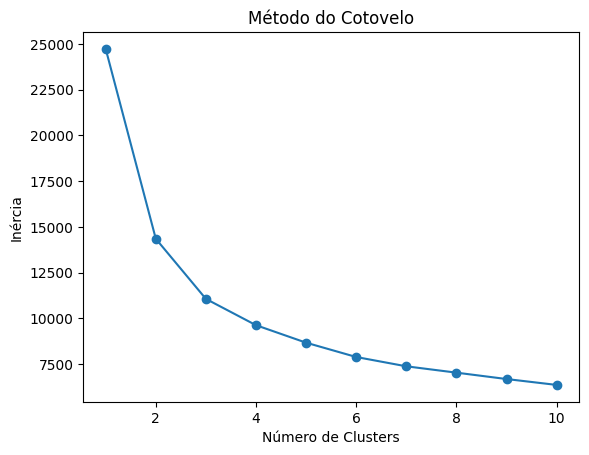

In [19]:
# @title Realizando o teste do cotovelo

# Lista para armazenar as inertias
inertias = []

# Testar diferentes números de clusters
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
    kmeans.fit(values)
    inertias.append(kmeans.inertia_)

# Plotar o gráfico do cotovelo
plt.plot(range(1, 11), inertias, marker='o')
plt.title('Método do Cotovelo')
plt.xlabel('Número de Clusters')
plt.ylabel('Inércia')
plt.show()

In [20]:
# @title Avaliando a sihoueta
# @markdown Calcula a coesão (media das distancias entre todos os pontos entre o cluster) e tenta minimizar esse valor e calcula a separação (media das distancias entre uma amostra e os outros clusters) e tenta maximizar

# Testar diferentes números de clusters
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42,n_init=10)
    cluster_labels = kmeans.fit_predict(values)

    silhouette_avg = silhouette_score(values, cluster_labels)
    print(f"Para n_clusters = {n_clusters}, a pontuação média da silhueta é: {silhouette_avg}")

Para n_clusters = 2, a pontuação média da silhueta é: 0.36629659988263974
Para n_clusters = 3, a pontuação média da silhueta é: 0.2746433068523762
Para n_clusters = 4, a pontuação média da silhueta é: 0.26441883193240145
Para n_clusters = 5, a pontuação média da silhueta é: 0.232282395458886
Para n_clusters = 6, a pontuação média da silhueta é: 0.2333934991673995
Para n_clusters = 7, a pontuação média da silhueta é: 0.22604839818994044
Para n_clusters = 8, a pontuação média da silhueta é: 0.2138430500639582
Para n_clusters = 9, a pontuação média da silhueta é: 0.20339201332470389
Para n_clusters = 10, a pontuação média da silhueta é: 0.20481178359285232


In [21]:
# @title Avaliando o Indice Calinski-Hazabasz
# @markdown Índice de Calinski-Harabasz: Mede a razão entre a dispersão entre clusters e a dispersão dentro dos clusters. Valores mais altos indicam melhor clusterização.

# Testar diferentes números de clusters

for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(values)

    ch_index = calinski_harabasz_score(values, cluster_labels)
    print(f"Para n_clusters = {n_clusters}, o índice Calinski-Harabasz é: {ch_index}")

Para n_clusters = 2, o índice Calinski-Harabasz é: 3570.8494791472235
Para n_clusters = 3, o índice Calinski-Harabasz é: 3047.743906745505
Para n_clusters = 4, o índice Calinski-Harabasz é: 2579.7636184953744
Para n_clusters = 5, o índice Calinski-Harabasz é: 2283.6115345843427
Para n_clusters = 6, o índice Calinski-Harabasz é: 2105.2494563616337
Para n_clusters = 7, o índice Calinski-Harabasz é: 1931.4508083431606
Para n_clusters = 8, o índice Calinski-Harabasz é: 1771.275776188942
Para n_clusters = 9, o índice Calinski-Harabasz é: 1662.374517353871
Para n_clusters = 10, o índice Calinski-Harabasz é: 1579.7070916848297


In [22]:
# @title Descrevendo estatisticamente os clusters para testar hipótese

for cluster in df_reduced["Cluster"].unique():
    print(f"Resumo estatístico do Cluster {cluster}:")
    display(df_reduced[df_reduced["Cluster"] == cluster].describe())
    print("\n" + "="*50 + "\n")

Resumo estatístico do Cluster 1:


PC1           PC2        Index         firm            BE  \
count  2.294000e+03  2.294000e+03  2294.000000  2294.000000  2.294000e+03   
mean  -1.075719e+10  8.204402e+07  2381.174368   402.612031  5.024642e+09   
std    2.719227e+10  5.426819e+09  1371.728380   235.271875  1.023479e+10   
min   -2.509885e+10 -4.790138e+10     0.000000     1.000000  3.790000e+05   
25%   -2.356406e+10 -4.145598e+08  1187.250000   199.000000  8.305442e+08   
50%   -2.000514e+10  8.486337e+08  2340.500000   388.000000  1.629808e+09   
75%   -1.042364e+10  1.426202e+09  3483.750000   581.000000  4.927228e+09   
max    2.333319e+11  2.790542e+10  4943.000000   860.000000  7.368309e+10   

                 ME       r.12.4           AC           CA           DR  \
count  2.294000e+03  2294.000000  2294.000000  2294.000000  2294.000000   
mean   9.467866e+09     0.007867     0.485082     0.761152     0.847628   
std    1.827669e+10     0.430005     0.118844     0.077830     0.088519   
min    1.597143e+06    -1.817558     0.194444     0.583333     0.500000   
25%    8.879707e+08    -0.213815     0.388889     0.722222     0.791667   
50%    3.156375e+09     0.005846     0.472222     0.750000     0.833333   
75%    9.540156e+09     0.240772     0.583333     0.805556     0.916667   
max    1.829543e+11     2.284861     0.777778     1.000000     1.000000   

               OFC          ECI  
count  2294.000000  2294.000000  
mean      0.682040     0.763368  
std       0.124103     0.090209  
min       0.333333     0.500000  
25%       0.600000     0.694444  
50%       0.700000     0.777778  
75%       0.766667     0.833333  
max       0.966667     1.000000



Resumo estatístico do Cluster 0:


PC1           PC2        Index         firm            BE  \
count  1.815000e+03  1.815000e+03  1815.000000  1815.000000  1.815000e+03   
mean   2.372173e+10 -4.218331e+08  2557.601102   434.088154  1.832942e+10   
std    1.053007e+11  2.002069e+10  1489.788042   256.736015  4.654807e+10   
min   -2.509053e+10 -1.116768e+11     4.000000     1.000000  5.600000e+04   
25%   -2.129830e+10 -2.187573e+09  1239.500000   209.000000  1.323678e+09   
50%   -1.343660e+10  8.793162e+08  2744.000000   454.000000  4.363126e+09   
75%    1.273278e+10  2.472370e+09  3843.500000   650.000000  1.091273e+10   
max    7.535930e+11  1.634050e+11  4935.000000   860.000000  4.341940e+11   

                 ME       r.12.4           AC           CA           DR  \
count  1.815000e+03  1815.000000  1815.000000  1815.000000  1815.000000   
mean   3.198017e+10    -0.017590     0.642332     0.895898     0.940794   
std    6.852016e+10     0.436821     0.113503     0.067092     0.066108   
min    6.094790e+06    -1.960695     0.305556     0.666667     0.708333   
25%    2.281246e+09    -0.246980     0.555556     0.833333     0.916667   
50%    7.221473e+09     0.007752     0.666667     0.888889     0.958333   
75%    2.539286e+10     0.236046     0.750000     0.944444     1.000000   
max    5.705210e+11     1.872125     0.833333     1.000000     1.000000   

               OFC          ECI  
count  1815.000000  1815.000000  
mean      0.843710     0.864754  
std       0.091903     0.075982  
min       0.566667     0.611111  
25%       0.800000     0.819444  
50%       0.866667     0.861111  
75%       0.900000     0.916667  
max       1.000000     1.000000



Resumo estatístico do Cluster 2:


PC1           PC2        Index        firm            BE  \
count  8.350000e+02  8.350000e+02   835.000000  835.000000  8.350000e+02   
mean  -2.200953e+10  6.915186e+08  2532.498204  430.123353  1.090756e+09   
std    5.122127e+09  1.192928e+09  1425.436953  244.737530  1.755001e+09   
min   -2.508968e+10 -1.268995e+10   181.000000   29.000000  2.320000e+05   
25%   -2.471547e+10  6.645029e+08  1379.500000  242.000000  1.603675e+08   
50%   -2.401293e+10  8.483385e+08  2415.000000  399.000000  5.193734e+08   
75%   -2.193902e+10  1.022025e+09  3781.500000  643.000000  1.272914e+09   
max    2.323480e+10  6.854908e+09  4906.000000  855.000000  1.548351e+10   

                 ME      r.12.4          AC          CA          DR  \
count  8.350000e+02  835.000000  835.000000  835.000000  835.000000   
mean   2.015728e+09    0.121039    0.401697    0.585961    0.631287   
std    3.437499e+09    0.467634    0.120335    0.076452    0.110889   
min    4.231305e+06   -1.280934    0.222222    0.361111    0.333333   
25%    2.350186e+08   -0.126346    0.305556    0.527778    0.583333   
50%    5.902200e+08    0.085569    0.388889    0.583333    0.625000   
75%    2.097821e+09    0.346233    0.500000    0.638889    0.708333   
max    3.484827e+10    5.134580    0.694444    0.777778    1.000000   

              OFC         ECI  
count  835.000000  835.000000  
mean     0.500439    0.552528  
std      0.126234    0.118607  
min      0.233333    0.305556  
25%      0.400000    0.472222  
50%      0.466667    0.555556  
75%      0.600000    0.638889  
max      0.866667    0.861111

# Confirmamos a hipótese 1!
 Testar via clusterização o que foi mostrado no artigo, ou seja, empresas com alto DR tem retornos baixos.

In [23]:
cluster_2_data = df_reduced[df_reduced["Cluster"] == "2"]

values_cluster_2 = cluster_2_data[["AC","CA","DR","OFC","ECI"]].values

kmeans_cluster_2 = KMeans(n_clusters=3, random_state=42, n_init=10)
cluster_2_data['SubCluster'] = kmeans_cluster_2.fit_predict(values_cluster_2)

<ipython-input-23-5eab21e957ce>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [24]:
fig = px.scatter(cluster_2_data, x='PC1', y='PC2', color='SubCluster',
                 hover_data=["Index", "firm", "BE", "ME", "r.12.4", "AC", "CA", "DR", "OFC", "ECI"],
                 title='Sub-Clusterização do Cluster 2')
fig.show()

# 3. A análise 3 foi concluída!
Visualizar o cluster de empresas com alto retorno, ver o tipo de empresa, tamanho, valor de mercado.

In [25]:
for cluster in cluster_2_data["SubCluster"].unique():
    print(f"Resumo estatístico do Cluster {cluster}:")
    display(cluster_2_data[cluster_2_data["SubCluster"] == cluster].describe())
    print("\n" + "="*50 + "\n")

Resumo estatístico do Cluster 2:


PC1           PC2        Index        firm            BE  \
count  3.470000e+02  3.470000e+02   347.000000  347.000000  3.470000e+02   
mean  -2.169287e+10  8.246874e+08  2571.553314  437.386167  1.339345e+09   
std    4.826657e+09  7.322242e+08  1382.208737  239.412638  1.939582e+09   
min   -2.508968e+10 -2.306927e+09   181.000000   29.000000  2.320000e+05   
25%   -2.465395e+10  6.244087e+08  1512.500000  261.000000  1.862615e+08   
50%   -2.383103e+10  8.475554e+08  2415.000000  399.000000  5.394570e+08   
75%   -2.159116e+10  1.069958e+09  3762.000000  632.000000  1.518928e+09   
max   -3.924831e+09  4.234722e+09  4815.000000  845.000000  1.052235e+10   

                 ME      r.12.4          AC          CA          DR  \
count  3.470000e+02  347.000000  347.000000  347.000000  347.000000   
mean   2.191558e+09    0.100500    0.501281    0.622398    0.700288   
std    3.179469e+09    0.554357    0.090310    0.073032    0.105067   
min    4.231305e+06   -1.280934    0.277778    0.472222    0.458333   
25%    2.539801e+08   -0.199414    0.444444    0.583333    0.625000   
50%    7.534239e+08    0.071744    0.500000    0.611111    0.708333   
75%    2.274512e+09    0.307985    0.583333    0.666667    0.750000   
max    1.472955e+10    5.134580    0.694444    0.777778    1.000000   

              OFC         ECI  SubCluster  
count  347.000000  347.000000       347.0  
mean     0.458405    0.557477         2.0  
std      0.089218    0.091086         0.0  
min      0.233333    0.333333         2.0  
25%      0.400000    0.500000         2.0  
50%      0.466667    0.555556         2.0  
75%      0.533333    0.611111         2.0  
max      0.700000    0.750000         2.0



Resumo estatístico do Cluster 1:


PC1           PC2        Index        firm            BE  \
count  2.190000e+02  2.190000e+02   219.000000  219.000000  2.190000e+02   
mean  -2.339254e+10  5.708149e+08  2488.945205  418.036530  4.280267e+08   
std    3.393673e+09  9.356146e+08  1336.625515  224.506142  5.689762e+08   
min   -2.507679e+10 -3.680616e+09   325.000000   63.000000  4.180000e+05   
25%   -2.487055e+10  7.663060e+08  1369.500000  242.000000  9.657200e+07   
50%   -2.451756e+10  8.365324e+08  2956.000000  485.000000  2.384650e+08   
75%   -2.395466e+10  9.154094e+08  3502.500000  583.000000  5.278455e+08   
max   -7.409746e+09  1.280370e+09  4869.000000  852.000000  3.282128e+09   

                 ME      r.12.4          AC          CA          DR  \
count  2.190000e+02  219.000000  219.000000  219.000000  219.000000   
mean   1.171709e+09    0.179414    0.286149    0.531456    0.577055   
std    2.475810e+09    0.408906    0.051869    0.053912    0.094697   
min    1.116357e+07   -1.048414    0.222222    0.388889    0.416667   
25%    1.439934e+08   -0.031036    0.222222    0.500000    0.541667   
50%    3.690042e+08    0.125915    0.305556    0.527778    0.583333   
75%    7.014696e+08    0.404454    0.333333    0.555556    0.625000   
max    1.511550e+10    1.527193    0.416667    0.611111    0.833333   

              OFC         ECI  SubCluster  
count  219.000000  219.000000       219.0  
mean     0.417199    0.441400         1.0  
std      0.100323    0.105278         0.0  
min      0.266667    0.305556         1.0  
25%      0.333333    0.361111         1.0  
50%      0.400000    0.416667         1.0  
75%      0.450000    0.472222         1.0  
max      0.666667    0.722222         1.0



Resumo estatístico do Cluster 0:


PC1           PC2        Index        firm            BE  \
count  2.690000e+02  2.690000e+02   269.000000  269.000000  2.690000e+02   
mean  -2.129205e+10  6.180039e+08  2517.576208  430.594796  1.309630e+09   
std    6.323814e+09  1.727421e+09  1549.037130  266.844907  1.994403e+09   
min   -2.507891e+10 -1.268995e+10   343.000000   64.000000  6.241000e+06   
25%   -2.452029e+10  6.375228e+08   965.000000  165.000000  2.046420e+08   
50%   -2.374811e+10  8.889342e+08  2168.000000  353.000000  9.755940e+08   
75%   -2.045150e+10  1.242189e+09  4010.000000  681.000000  1.655660e+09   
max    2.323480e+10  6.854908e+09  4906.000000  855.000000  1.548351e+10   

                 ME      r.12.4          AC          CA          DR  \
count  2.690000e+02  269.000000  269.000000  269.000000  269.000000   
mean   2.476052e+09    0.100008    0.367307    0.583333    0.586431   
std    4.230821e+09    0.379454    0.086063    0.069174    0.078304   
min    1.233600e+07   -0.935685    0.222222    0.361111    0.333333   
25%    2.920704e+08   -0.105361    0.305556    0.527778    0.541667   
50%    7.329551e+08    0.071364    0.361111    0.555556    0.583333   
75%    3.071590e+09    0.337830    0.416667    0.611111    0.666667   
max    3.484827e+10    1.313343    0.666667    0.777778    0.750000   

              OFC         ECI  SubCluster  
count  269.000000  269.000000       269.0  
mean     0.622429    0.636617         0.0  
std      0.090768    0.082643         0.0  
min      0.433333    0.500000         0.0  
25%      0.566667    0.583333         0.0  
50%      0.633333    0.638889         0.0  
75%      0.700000    0.666667         0.0  
max      0.866667    0.861111         0.0

# A análise 2 foi concluída!
Achar um cluster de empresas com alto retorno e analisar a soma ponderada dos índices das mesmas.

In [27]:
# Separando as variáveis independentes (X) e a variável dependente (y)
X = df[['AC', 'CA', 'DR', 'OFC', 'ECI']]
y = df['r.12.4']

# Dividindo os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Criando o modelo de regressão linear
model = LinearRegression()

# Treinando o modelo
model.fit(X_train, y_train)

# Fazendo previsões no conjunto de teste
y_pred = model.predict(X_test)

# Avaliando o modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('Erro Quadrático Médio (MSE):', mse)
print('Coeficiente de Determinação (R²):', r2)

Erro Quadrático Médio (MSE): 0.1917712152660591
Coeficiente de Determinação (R²): 0.015361858656263272


# A análise 4 foi concluída!
Aplicar uma regressão para tentar estimar o retorno das empresas com base na soma pondera dos índices.

Podemos melhorar o MSE removendo os outliers (pois o MSE é sensível aos outliers). O valor do MSE é relativamente baixo, explicando o modelo.

o R2 nos diz que o modelo é um pouco melhor que a média das variabilidades dos dados.